# Data Sciene Bowl
* The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. 


In [15]:
print("Hello World")

Hello World


In [10]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Hello


In [16]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [17]:
# first folder
print(train_ids[0])
print(test_ids[0])

cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9d3fc0c214a4e5d32bd
44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078


In [7]:
len(train_ids), len(test_ids)

(670, 65)

# Data
* Training(images and their masks)  and testing samples(images)

In [36]:
# set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# initiailize empty numpy array
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

# go over the training set dirs
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    '''training set conssits of raw images and their seperate masks
    '''
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # add image in training set
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        # stitch all the masks together to one mask
        mask = np.maximum(mask, mask_)
    # add the masks in training set
    Y_train[n] = mask

# go over test samples
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img


    print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:05<00:00,  4.90it/s]

Getting and resizing test images ... 



 11%|█         | 7/65 [00:00<00:00, 69.28it/s]

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


 20%|██        | 13/65 [00:00<00:00, 65.51it/s]

Done!
Done!
Done!


 31%|███       | 20/65 [00:00<00:00, 64.07it/s]

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


 42%|████▏     | 27/65 [00:00<00:00, 62.71it/s]

Done!
Done!
Done!


 49%|████▉     | 32/65 [00:00<00:00, 56.58it/s]

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


 75%|███████▌  | 49/65 [00:00<00:00, 66.07it/s]

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


 97%|█████████▋| 63/65 [00:00<00:00, 62.66it/s]

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


100%|██████████| 65/65 [00:01<00:00, 63.07it/s]

Done!


In [37]:
print(X_train.shape, Y_train.shape)
print(X_test.shape)

(670, 128, 128, 3) (670, 128, 128, 1)
(65, 128, 128, 3)


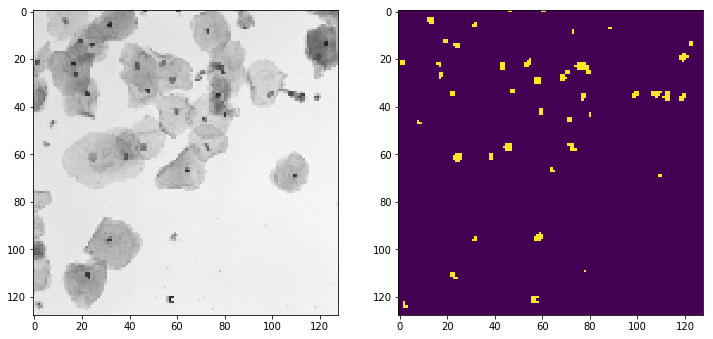

In [40]:
idx = random.randint(0, len(X_train))

fig=plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(X_train[idx])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(np.squeeze(Y_train[idx]))

# Fancy metric

In [41]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build and train

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [42]:
'''Different activation function an added dropout
'''

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 128, 128, 16) 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

# Train

In [43]:
# bs small due to less training samples
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('dbs.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=20, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - 12s 20ms/step - loss: 0.3225 - mean_iou: 0.4425 - val_loss: 0.1770 - val_mean_iou: 0.5351

Epoch 00001: val_loss improved from inf to 0.17705, saving model to dbs.h5
Epoch 2/20
603/603 [==============================] - 5s 9ms/step - loss: 0.1436 - mean_iou: 0.5898 - val_loss: 0.1268 - val_mean_iou: 0.6381

Epoch 00002: val_loss improved from 0.17705 to 0.12677, saving model to dbs.h5
Epoch 3/20
603/603 [==============================] - 5s 9ms/step - loss: 0.1203 - mean_iou: 0.6679 - val_loss: 0.1198 - val_mean_iou: 0.6902

Epoch 00003: val_loss improved from 0.12677 to 0.11982, saving model to dbs.h5
Epoch 4/20
603/603 [==============================] - 5s 9ms/step - loss: 0.1089 - mean_iou: 0.7071 - val_loss: 0.1161 - val_mean_iou: 0.7204

Epoch 00004: val_loss improved from 0.11982 to 0.11608, saving model to dbs.h5
Epoch 5/20
603/603 [==============================] - 5s 9ms/step - l

# Pred

In [51]:
# Predict on train, val and test
model = load_model('dbs.h5', custom_objects={'mean_iou': mean_iou})
#preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_test = model.predict(X_test, verbose=1)

#preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 1s 22ms/step


In [54]:
len(preds_test_upsampled)

65

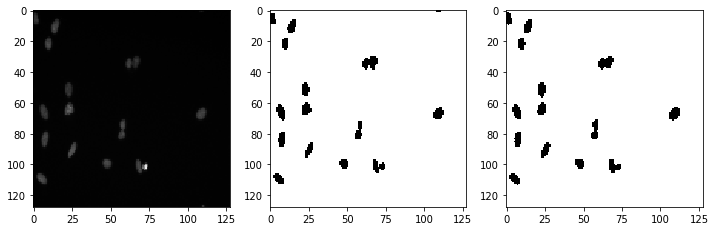

In [84]:
# Perform a sanity check on some random training samples
idx = random.randint(0, len(preds_test))

fig=plt.figure(figsize=(12, 12))

# input image
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X_train[idx])

# ground truth
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(np.squeeze(Y_train[idx]), cmap='binary')

# predicted result
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(np.squeeze(preds_train_t[idx]), cmap='binary')

In [80]:
print("The End.")

The End.
